#### Inferences (example 03)

In [1]:
import memocell as me
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle

/Users/m651s/Documents/Studium/PhD/01_projects/memo_cell/memocell/memocell/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##### Parameter estimation and model probabilities

In [2]:
# the basic input to do inferences in memocell is: 
# memocell data object + list of memocell networks

# hence, first we load a memocell data object of a 
# process of cell divisions (see example 02)
# (we know the ground truth model)
data_10 = pickle.load(open('data_cell_div_t10.pickle', 'rb'))
# print(data_10) -> memocell.data.Data object

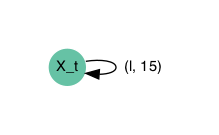

In [3]:
# here we define the list of networks and their respective 
# parameter settings for the inference

# make_net returns a memocell network for a cell division process 
# with broad or tight Erlang division times depending on substeps n
def make_net(n):
    net = me.Network(f'net_div_erl{n}')
    net.structure([{'start': 'X_t', 'end': 'X_t',
                 'rate_symbol': 'l',
                 'type': 'S -> S + S',
                 'reaction_steps': n}])
    return net

# we specify 7 different models with increasingly tight division times
nets = [make_net(n) for n in [1, 5, 10, 15, 20, 25, 30]]
# NOTE: nets[0] (n=1) contains the Markov model with 
# exponentially distributed division times
# NOTE: in the following "*len(nets)" is used to specify the 
# same settings for all networks

# these settings are known from simulations (see example 01)
# (initial values encode the single cell initial distribution)
variables = [{'X_t': ('X_t', )}]*len(nets)
initial_values_types = ['synchronous']*len(nets)
initial_values = [{('X_t',): 1.0, # mean (t=0)
                   ('X_t', 'X_t'): 0.0} # variance (t=0)
                 ]*len(nets)

# for each parameter, ranges have to be provided
# these specify uniform parameter prior distributions
theta_bounds = [{'l': (0.0, 0.5)}]*len(nets)

# specify time values for which the models are simulated in the inference
# NOTE: the first time value corresponds to the initial condition
# NOTE: if odeint gives a warning during the inference, you might 
# want to increase the "denseness" for better numerical integration
time_values = [np.linspace(0.0, 10.0, num=11)]*len(nets)

# plot the main layer of one of the networks
me.plots.net_main_plot(nets[3]);

# print(nets) -> list of memocell networks: [<memocell.network.Network at 0x7fc50b85a0d0>, ...]

In [4]:
# the memocell Bayesian inference based on nested sampling is run like this
# NOTE: this should not need much more than ≈7 minutes (in parallel mode)
est_res = me.selection.select_models(nets, variables,
                                    initial_values_types, initial_values,
                                    theta_bounds, data_10, sim_mean_only=False,
                                    time_values=time_values, parallel=True)

# NOTE: we strongly recommend to compute larger inferences via the terminal 
# and save and load estimation results with pickle

# NOTE: you may notice that larger networks (more hidden variables) take 
# longer to run; indeed, the moment equations to be solved scale quadratically 
# with the number of hidden variables; if mean-only inferences is all that is 
# needed use sim_mean_only=True to speed up the run time (≈1 minute total)

# NOTE: select_models is a wrapper for the estimation class, looping over 
# the list of models; hence est_res is a list of estimation objects
# print(est_res) -> [<memocell.estimation.Estimation at 0x7fc50bbddcd0>, ...]

# NOTE: if the progress bar does not show up nicely, you may need 
# to install the jupyter widgets extension:
# https://ipywidgets.readthedocs.io/en/stable/user_install.html#installing-the-jupyterlab-extension

  0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# we can read out logarithmic evidences from the estimation results
log_evids = np.array([est.bay_est_log_evidence for est in est_res])
print(log_evids)

# NOTE: evidence values are the prime output of nested sampling and also 
# the basis for Bayesian-averaged inferences over model sets in memocell; 
# evidences do not depend on the set of models / are internal to each model; 
# in this sense they provide future-proof information as more models can 
# be added later on, without recomputing the previous model set

# within some numerical error (est.bay_est_log_evidence_error), one should get:
# [-50.18391703 -10.29535513  -3.57241495  -2.9415347   -3.02019749
#  -3.25885459  -3.4702607 ]

[-50.26422795 -10.4035954   -3.59503106  -2.92606111  -3.08397907
  -3.32012177  -3.49768677]


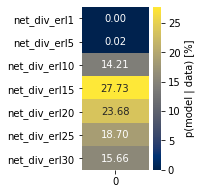

In [6]:
# posterior model probabilities are computed directly from the evidences
model_probs = me.selection.compute_model_probabilities(est_res)

# NOTE: the posterior probability and the Bayes factor of a given model 
# always depends on the overall used model set (in contrast to 
# model internal evidence values); in this sense, high model 
# probabilities might not mean much, if the overall model set is unable to 
# explain the data and/or not exhaustive
# NOTE: it is worth to note that models (or parameter 
# regions within each model) that are not part of the model selection 
# at all, are implicitly given a prior probability of zero! hence,
# they can also never gain any posterior weight (see Cromwell's rule)

# we also read out the model names
net_names = [est.net.net_name for est in est_res]

# and plot the posterior model probabilities as a heatmap (in %)
plt.figure(figsize=(1.5,3))
df = pd.DataFrame(np.array([model_probs * 100.0]).T, index=net_names)
sns.heatmap(df, cmap='cividis', annot=True, fmt='.2f', cbar_kws={'label': 'p(model | data) [%]'});

# we might conclude:
# 1) the Markov model (net_div_erl1) is strongly rejected
# 2) the most favoured model is erl15; this was the ground truth model for 
#    these made up data, so memocell correctly recovers the underlying process
# 3) tighter division times (e.g., erl30) are less favoured, but are hard 
#    to reject: they are part of the minimal model set comprising at (least) 
#    95% cumulated posterior probability

In [7]:
# for larger inference runs the following code snippet 
# might be useful to look at the top models
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
print(net_names_sorted)
print(model_probs_sorted)

# as indicated above, one can obtain a top model set by
# (minimal model set with >95% cumulated posterior)
num_top_models = model_probs_sorted.cumsum().searchsorted(0.95) + 1
print(num_top_models)
# -> 5, i.e. the first 5 models have > 95% posterior
# (rejecting net_div_erl1 and net_div_erl5)

['net_div_erl15' 'net_div_erl20' 'net_div_erl25' 'net_div_erl30'
 'net_div_erl10' 'net_div_erl5' 'net_div_erl1']
[2.77343165e-01 2.36828829e-01 1.87016144e-01 1.56589847e-01
 1.42065135e-01 1.56879280e-04 7.66148275e-22]
5


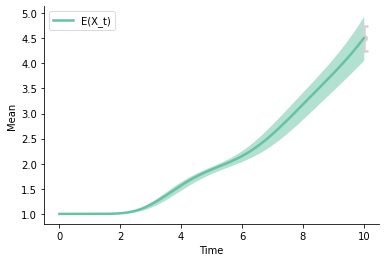

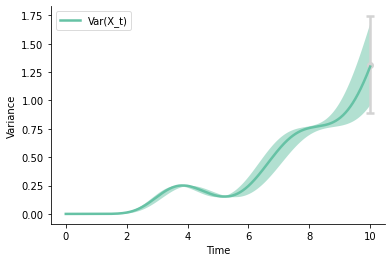

In [8]:
# we can inspect the model fits; the best model of 
# the tested model set can explain the data well
# (it was the data generating model)
est_i = net_names.index('net_div_erl15')

me.plots.est_bestfit_mean_plot(est_res[est_i])
me.plots.est_bestfit_variance_plot(est_res[est_i]);

# NOTE: the bands below are 95% credible intervals of 
# posterior model simulations; the best-fit line is the 
# median (50th percentile) of posterior model simulations

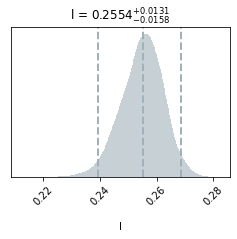

In [9]:
# parameter estimation:
# the in silico data was produced with l=0.255,
# so memocell recovers the underlying process
me.plots.est_corner_kernel_plot(est_res[est_i]);

# NOTE: the dashed lines indicate 95% credible 
# interval (by 2.5th and 97.5th percentiles) and 
# median (50th percentile)

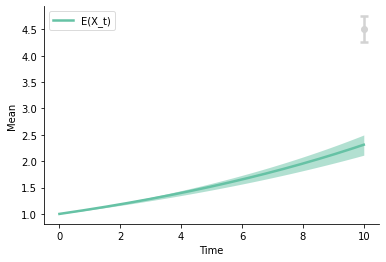

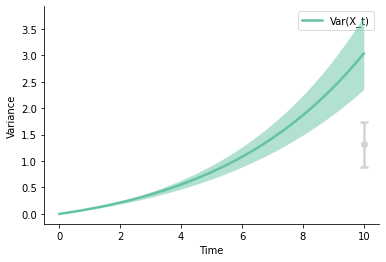

In [10]:
# why are other models worse? a look at model fits

# the markov model / exponential division times (CV=1)
# creates a too large variability, so that mean and 
# variance of the data cannot be explained simultaneously
est_i = net_names.index('net_div_erl1')
me.plots.est_bestfit_mean_plot(est_res[est_i])
me.plots.est_bestfit_variance_plot(est_res[est_i]);

# NOTE: for the erl30 models and higher, the effect is 
# exactly opposite; they create a too low variability

##### Inference of waiting time distributions

In [11]:
# instead of selecting the top models or rejecting the worst models,
# we recommend Bayesian-averaged inference over the whole model set for 
# many quantities of interest; waiting time distributions are one of  
# the main applications of this procedure (as shown below), it 
# can however be adapted and applied to many other quantities as well

# NOTE: please look at the methods part of our paper or the 
# readthedocs webpage for more in depth info; in brief: 
# we want to know p(X|data), the posterior of X (given the data),
# where X can be the waiting time density or anything else; 
# we obtain bona fide samples of this distribution by:
# 1) sample a model according to the model posterior probabilities
# 2) sample a parameter set for that model, given its parameter posterior
# 3) compute X from the drawn model and parameter info, and repeat with 1)

# we define this helper function to obtain samples of 
# the posterior waiting time distribution
# (as Bayesian-averaged inference over all models)
def waiting_time_distr_samples(times, est_res, samples, mprior):
    """Compute samples of the posterior waiting time density for 
    the cell division process.
    
    Parameters
    ----------
    times : 1d numpy.ndarray
        Array of waiting times for which the probability 
        density function (pdf) of the waiting time 
        distribution is computed.
    est_res : list of memocell.estimation.Estimation
        A list of memocell estimation objects for the models;
        for example obtained by the `select_models` function.
    samples : int
        Number of waiting time samples to compute.
    mprior : None or 1d numpy.ndarray
        Array of prior model probabilities; if `mprior=None` (default) 
        an uniform model prior will be used: `p(M)=1/n` where 
        `n` is the total number of models. If a custom prior is specified, 
        it has to have the same length `n` as `est_res`.

    Returns
    -------
    pdf_samples : 2d numpy.ndarray
        Posterior samples of the waiting time density with 
        shape `(len(times), samples)`.
    """
    # get the posterior model probabilities from the estimation result
    model_probs = me.selection.compute_model_probabilities(est_res, mprior=mprior)

    # preallocate the pdf samples array
    pdf_samples = np.zeros((times.shape[0], samples))

    # optional: count how often the individual models will be drawn
    model_type_counts = np.zeros((len(est_res),))

    for i in range(samples):
        # sample a random model 'est' according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = est_res[model_rand]
        
        # optional: add one count to the drawn model
        model_type_counts[model_rand] += 1

        # sample a random 'theta' (parameters) according to p(theta|M, D)
        inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
        theta_ind = np.random.choice(inds, replace=True)
        theta = est.bay_est_samples_weighted[theta_ind, :]

        ### this part here might need to be adapted for other
        ### model structures (topologies and/or waiting times)
        # now, given the model and theta info, we want to compute
        # the waiting time pdf for the cell division reaction
        
        # we have to read out the Erlang step number for 
        # the division reaction module and say at which 
        # index the division rate is stored in the theta array;
        # here, there is just one reaction and rate, hence:
        module_id = 0
        theta_id = 0
        
        # compute Erlang/Gamma shape and scale parameters for 
        # the division reaction
        theta_shape = est.net.net_modules[module_id]['module_steps']
        theta_scale = 1.0/(theta[theta_id]*theta_shape)
        
        # compute the density
        density = stats.gamma.pdf(times, a=theta_shape, scale=theta_scale)
        ###
        
        # store the posterior density sample and repeat
        pdf_samples[:, i] = density
    
    # this shows how often each model was drawn
    print(model_type_counts)
    return pdf_samples

In [12]:
# now we use our helper method to obtain 1000 
# posterior samples of the division time distribution
samples = 1000
times = np.linspace(0.0, 10.0, num=200)
mprior = None # if None, a uniform model prior is used

pdf_samples = waiting_time_distr_samples(times, est_res, samples, mprior)

[  0.   0. 149. 284. 224. 173. 170.]


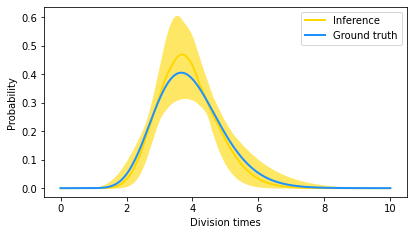

In [13]:
# to visualize the posterior waiting time pdf samples
# we compute the median pdf value (element-wise for 
# each time point) and a 95% credible interval
y_95_lower = np.percentile(pdf_samples, 2.5, axis=1)
y_median = np.percentile(pdf_samples, 50.0, axis=1)
y_95_upper = np.percentile(pdf_samples, 97.5, axis=1)

plt.figure(figsize=(6.5, 3.5))
plt.fill_between(times, y_95_lower, y_median, color='gold', alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(times, y_median, y_95_upper, color='gold', alpha=0.6, linewidth=0.0, zorder=100)
plt.plot(times, y_median, color='gold', lw=2, zorder=200, label='Inference')

# we know the ground truth model and hence also the 
# waiting time pdf; even from this sparse snapshot 
# data, memocell recovers a quite good estimate
plt.plot(times, stats.gamma.pdf(times, a=15, scale=1.0/(15*0.255)), 
         color='dodgerblue', lw=2, zorder=200, label='Ground truth')

plt.ylabel('Probability')
plt.xlabel('Division times')
plt.legend();

In [14]:
### some additional remarks below for people who 
### want to go further (multi-reaction models, 
### phase-type waiting times, etc.)

# for more complicated models you need to read out
# the hidden step numbers from the correct module
# ('module_id' in 'waiting_time_distr_samples')
# you can take this info from
est = est_res[0]
print(est.net.net_modules)

# also you need to get the right rate from the 
# parameter array ('theta' and 'theta_id')
# the order in 'theta' corresponds to
print(est.net.net_theta_symbolic)
# and you can look up your rate symbol with
print(est.net.net_rates_identifier)

### as an example: a code snippet to read out 
### a phase-type waiting time pdf that was 
### implemented via 2 parallel Erlang channels;
### there are now 2 module_id's and theta_id's
# n_d1 = est.net.net_modules[0]['module_steps']
# n_d2 = est.net.net_modules[1]['module_steps']
# rate_1 = theta[0]
# rate_2 = theta[1]

### obtain the phase-type density with utils methods
### (see also example 01)
# alpha, S = me.utils.phase_type_from_parallel_erlang2(rate_1, rate_2, n_d1, n_d2)
# density = me.utils.phase_type_pdf(alpha, S, times)
### this code can be plugged into 'waiting_time_distr_samples'
### in the '###' quoted block

[{'module': 'module_0', 'start-end': ('X_t', 'X_t'), 'start-end_ident': ('Z_0', 'Z_0'), 'sym_rate': 'l', 'sym_rate_ident': 'theta_0', 'type': 'S -> S + S', 'module_steps': 1}]
['theta_0']
{'theta_0': 'l'}


##### Inference of model topologies

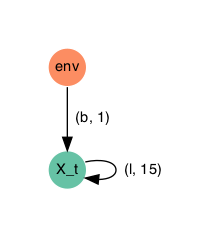

In [15]:
# memocell can also be used to infer posterior
# probabilities of network topologies;
# with 'topology' we mean the connectivity of the networks 
# *beyond* the structure to implement the waiting times;
# for example, how different cell types are connected 
# through differentiation reactions in more complex 
# lineage pathways

# instead of looking at such lineage topologies (check 
# our release paper for that), we continue with our 
# cell division process here:
# we want to find out whether our cell number data might 
# also be explained by an alternative model topology,
# where -- next to cell divisions from the single 
# starting cell -- cells might also influx from an 
# unknown outside compartment

# to analyse this, we create a second model set of 
# 7 new models that now have an additonal influx
def make_net_influx(n):
    net = me.Network(f'net_div_erl{n}_influx')
    net.structure([{'start': 'X_t', 'end': 'X_t',
                 'rate_symbol': 'l',
                 'type': 'S -> S + S',
                 'reaction_steps': n},
                  {'start': 'env', 'end': 'X_t',
                 'rate_symbol': 'b',
                 'type': '-> E',
                 'reaction_steps': 1}])
    return net

nets_influx = [make_net_influx(n) for n in [1, 5, 10, 15, 20, 25, 30]]
me.plots.net_main_plot(nets_influx[3]);

In [16]:
# we run the memocell inference also for this second model set;
# we mostly re-use previously defined input settings, just the 
# uniform parameter prior has to include the second rate 'b' now
theta_bounds_influx = [{'l': (0.0, 0.5), 'b': (0.0, 0.5)}]*len(nets)

est_res_influx = me.selection.select_models(nets_influx, variables,
                                    initial_values_types, initial_values,
                                    theta_bounds_influx, data_10, sim_mean_only=False,
                                    time_values=time_values, parallel=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
# we report the new evidence values
log_evids_influx = np.array([est.bay_est_log_evidence for est in est_res_influx])
print(log_evids_influx)

# the evidence values for the division+influx topology
# within some numerical error (est.bay_est_log_evidence_error)
# [-16.67979584 -13.56244421  -7.55174976  -6.16397056  -5.71891203
#   -5.51918497  -5.43311092]

# and as evidence values are future-proof, we can combine the previous 
# simple division topology run with the new division+influx topology run;
# this creates a list of 7+7=14 memocell estimation objects
est_topology = est_res + est_res_influx

# we then compute the posterior model probabilities, within 
# the context of these 14 models
model_probs_topology = me.selection.compute_model_probabilities(est_topology)

[-16.69947269 -13.62113393  -7.67858624  -6.22043331  -5.81549395
  -5.60137797  -5.48057753]


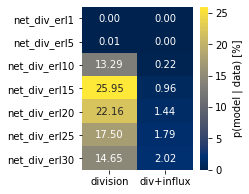

In [18]:
# we plot the model probabilities separated by two 
# columns indicating the two different topologies

# one can observe that most of the posterior weight
# is distributed among the models without influx
plt.figure(figsize=(2.5,3))
df = pd.DataFrame(np.array([model_probs_topology[:7] * 100.0, model_probs_topology[7:] * 100.0]).T, 
                  columns=['division', 'div+influx'], index=net_names)
sns.heatmap(df, cmap='cividis', annot=True, fmt='.2f', cbar_kws={'label': 'p(model | data) [%]'});

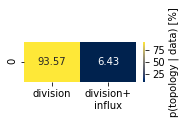

In [19]:
# now, how to compute the posterior probabilities of 
# the topologies 'division' vs. 'division+influx'?
# this is quite simple and can be applied in general:
# sum together the model probabilities that 
# belong to each topology (or hypothesis)

# NOTE: the topologies have to categorize the models 
# into disjoint sets; then also p(topology|data) is
# a discrete (posterior) probability distribution

# NOTE: on a more technical basis, this can be again 
# viewed as the procedure of Bayesian-averaged inference 
# over the complete model space (see webpage or methods 
# part of the release paper)

# we obtain the topology probabilities by summing the
# first 7 and last 7 model probabilities, respectively
topology_prob_div = np.sum(model_probs_topology[:7])
topology_prob_div_influx = np.sum(model_probs_topology[7:])

# and visualise the results
plt.figure(figsize=(2.5,0.75))
df = pd.DataFrame(np.array([[topology_prob_div * 100.0], [topology_prob_div_influx * 100.0]]).T, 
                  columns=['division', 'division+\ninflux'])
sns.heatmap(df, cmap='cividis', annot=True, fmt='.2f', cbar_kws={'label': 'p(topology | data) [%]'});

# the results show that the simpler division topology
# is strongly favoured over the more complex 
# division+influx topology; so, also here, memocell 
# correctly favors the underlying ground truth topology

# this result also shows that Bayesian inference 
# in general, and memocell in particular, naturally
# embody Occam's razor: one should favour the simplest 
# explanation (with the fewest assumptions) that 
# already fully captures the data; in other terms, this 
# protects against overfitting